In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kneed as kn
import plotly.graph_objects as go
import random

In [3]:
from plotly.subplots import make_subplots

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors

In [4]:
from sklearn.metrics import *
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [5]:
df = pd.read_csv('train_pca.csv')

In [6]:
df.head()

,Unnamed: 0,Popularity and Visibility,Quality and Production Year,Awards and Duration,Year and Duration,Duration and Rating
0,0,-0.346579,0.098145,-0.806746,-0.427913,0.328098
1,1,-1.618868,-0.365689,0.405130,-0.254094,-0.970461
2,2,-0.763450,-0.721884,0.720200,0.806694,0.062175
3,3,-0.506804,0.166461,-0.184220,1.056516,-0.478649
4,4,7.945215,-0.716464,-1.416758,-0.013609,0.743721


In [7]:
df.describe()

,Unnamed: 0,Popularity and Visibility,Quality and Production Year,Awards and Duration,Year and Duration,Duration and Rating
count,15925.000000,1.592500e+04,1.592500e+04,1.592500e+04,1.592500e+04,1.592500e+04
mean,7962.000000,4.640279e-17,-2.097049e-17,5.309550e-17,1.784723e-18,-8.923614e-18
std,4597.295854,2.063024e+00,1.196257e+00,1.043604e+00,9.702996e-01,9.016430e-01
min,0.000000,-2.125705e+00,-4.153832e+00,-5.442170e+00,-4.154836e+00,-5.957225e+00
25%,3981.000000,-1.222967e+00,-7.264520e-01,-6.123275e-01,-5.709878e-01,-5.172481e-01
50%,7962.000000,-6.266554e-01,1.064962e-01,-6.461689e-02,2.753387e-02,3.319548e-02
75%,11943.000000,4.488364e-01,7.346950e-01,5.516331e-01,5.937905e-01,5.329868e-01
max,15924.000000,2.071558e+01,7.826389e+00,7.451328e+00,8.326927e+00,8.310961e+00


In [8]:
# del df['popularityIndex']
# del df['originalTitle']
# del df['rating']
# del df['titleType']
# del df['countryOfOrigin']
# del df['genres']
# del df['isAdult']
# del df['isRatable']
# del df['canHaveEpisodes']

In [9]:
df.head()

,Unnamed: 0,Popularity and Visibility,Quality and Production Year,Awards and Duration,Year and Duration,Duration and Rating
0,0,-0.346579,0.098145,-0.806746,-0.427913,0.328098
1,1,-1.618868,-0.365689,0.405130,-0.254094,-0.970461
2,2,-0.763450,-0.721884,0.720200,0.806694,0.062175
3,3,-0.506804,0.166461,-0.184220,1.056516,-0.478649
4,4,7.945215,-0.716464,-1.416758,-0.013609,0.743721


In [10]:
#NORMALIZZAZIONE MINMAX O ZSCORE, COMMMENTARE UNA DELLE DUE RIGHE IN BASE AL TIPO DI NORMALIZZAZIONE CHE SI VUOLE UTILIZZARE
#NORMALIZZAZIONE MINMAX O ZSCORE, COMMMENTARE UNA DELLE DUE RIGHE IN BASE AL TIPO DI NORMALIZZAZIONE CHE SI VUOLE UTILIZZARE
#PER I NOSTRI DATI SEMBRA MEGLIO MIN/MAX
#PER I NOSTRI DATI SEMBRA MEGLIO MIN/MAX

# scaler = MinMaxScaler()

scaler = StandardScaler()

train_data = scaler.fit_transform(df)


In [11]:
def create_kdistance_graph(data, k):
  """Crea un grafico k-distance per i dati.

  Args:
    data: Un array numpy contenente i dati.
    k: Il numero di vicini da considerare.

  Returns:
    Un array numpy contenente le distanze k-esimo vicino per ogni punto.
  """

  # Calcola le distanze ai k vicini più vicini per ogni punto
  nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(data)
  distances, indices = nbrs.kneighbors(data)

  # Prendi la distanza dal k-esimo vicino più vicino
  distances = distances[:, k]
  distances = np.sort(distances, axis=0)

  return distances

In [12]:
# Esempio di utilizzo
epsilon_list = []

for k in range(2,51): # Numero di vicini
    distances = create_kdistance_graph(train_data, k)
    x = np.arange(len(distances))
    kn = KneeLocator(x, distances, curve='convex', direction='increasing')
    elbow_k = kn.elbow
    epsilon = distances[elbow_k]
    epsilon_list.append(epsilon)
    print("Epsilon ottimale secondo il metodo del gomito: k={} epsilon={}".format(k, epsilon))

media_epsilon = np.mean(epsilon_list)
print("La media degli epsilon è:", media_epsilon)


Epsilon ottimale secondo il metodo del gomito: k=2 epsilon=2.7854018617227965
Epsilon ottimale secondo il metodo del gomito: k=3 epsilon=3.1088588973420053
Epsilon ottimale secondo il metodo del gomito: k=4 epsilon=2.007097276085198
Epsilon ottimale secondo il metodo del gomito: k=5 epsilon=2.607355116092824
Epsilon ottimale secondo il metodo del gomito: k=6 epsilon=3.51806521439387
Epsilon ottimale secondo il metodo del gomito: k=7 epsilon=3.6205224225614354
Epsilon ottimale secondo il metodo del gomito: k=8 epsilon=3.039026351844605
Epsilon ottimale secondo il metodo del gomito: k=9 epsilon=1.8899650569940367
Epsilon ottimale secondo il metodo del gomito: k=10 epsilon=1.9487621477847008
Epsilon ottimale secondo il metodo del gomito: k=11 epsilon=1.8533655379144367
Epsilon ottimale secondo il metodo del gomito: k=12 epsilon=3.150230309647929
Epsilon ottimale secondo il metodo del gomito: k=13 epsilon=2.1628952392369807
Epsilon ottimale secondo il metodo del gomito: k=14 epsilon=2.1890

2.4974394633715784


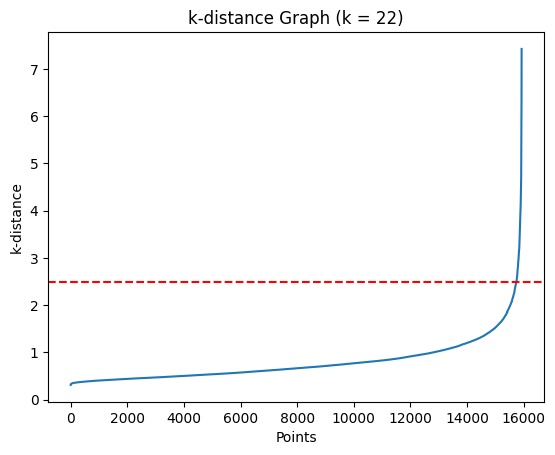

In [13]:
distances = create_kdistance_graph(train_data, 22)
kn = KneeLocator(x, distances, curve='convex', direction='increasing')
elbow_k = kn.elbow
epsilon = distances[elbow_k]
print(epsilon)

# Plotta il grafico
plt.plot(distances)
# Aggiungi la linea orizzontale
plt.axhline(y=epsilon, color='r', linestyle='--')
plt.xlabel('Points')
plt.ylabel('k-distance')
plt.title('k-distance Graph (k = 22)')
plt.show()

In [28]:
# density based clustering
print('DBSCAN')

for k in range(2, 7):

    dbscan = DBSCAN(eps=2.5, min_samples=k, metric='euclidean')
    dbscan.fit(train_data)

    print(k)

    hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))
    print('labels', dict(zip(bins, hist)))
    print('silhouette', silhouette_score(train_data[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1]))

DBSCAN
2
labels {np.int64(-1): np.int64(11), np.int64(0): np.int64(15898), np.int64(1): np.int64(2), np.int64(2): np.int64(14), np.int64(3): np.int64(0)}
silhouette 0.7133779193338156
3
labels {np.int64(-1): np.int64(13), np.int64(0): np.int64(15898), np.int64(1): np.int64(14), np.int64(2): np.int64(0)}
silhouette 0.7148418240331814
4
labels {np.int64(-1): np.int64(19), np.int64(0): np.int64(15894), np.int64(1): np.int64(12), np.int64(2): np.int64(0)}
silhouette 0.7070749555369431
5
labels {np.int64(-1): np.int64(24), np.int64(0): np.int64(15893), np.int64(1): np.int64(8), np.int64(2): np.int64(0)}
silhouette 0.6932920978477568
6
labels {np.int64(-1): np.int64(28), np.int64(0): np.int64(15891), np.int64(1): np.int64(6), np.int64(2): np.int64(0)}
silhouette 0.679822643117866


In [32]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

# Definisci i parametri per la grid search
param_grid = {
    'eps': np.arange(0.1, 3.2, 0.5),
    'min_samples': np.arange(1, 16, 3)
}

# Inizializza una lista per memorizzare i risultati
results = []

# Esegui la grid search
for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'], metric='euclidean')
    dbscan.fit(train_data)
    
    # Calcola il numero di cluster (escludendo il rumore)
    n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    
    # Calcola il silhouette score (escludendo i punti rumorosi)
    if n_clusters > 1:
        silhouette = silhouette_score(train_data[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1])
    else:
        silhouette = -1  # Silhouette score non definito per un singolo cluster
    
    # Memorizza i risultati
    results.append({
        'eps': params['eps'],
        'min_samples': params['min_samples'],
        'n_clusters': n_clusters,
        'silhouette': silhouette
    })

# Converti i risultati in un DataFrame per una visualizzazione più semplice
results_df = pd.DataFrame(results)

print(results_df)

    eps  min_samples  n_clusters  silhouette
0   0.1            1       15738    0.013015
1   0.1            4           0   -1.000000
2   0.1            7           0   -1.000000
3   0.1           10           0   -1.000000
4   0.1           13           0   -1.000000
5   0.6            1        2645   -0.469327
6   0.6            4          59   -0.391630
7   0.6            7          21   -0.298764
8   0.6           10          19   -0.293386
9   0.6           13           4   -0.029594
10  1.1            1         459   -0.201448
11  1.1            4           7    0.218524
12  1.1            7           3    0.302670
13  1.1           10           1   -1.000000
14  1.1           13           1   -1.000000
15  1.6            1         115    0.214114
16  1.6            4           4    0.599613
17  1.6            7           2    0.503977
18  1.6           10           1   -1.000000
19  1.6           13           1   -1.000000
20  2.1            1          37    0.412759
21  2.1   

In [25]:
train_data = pd.DataFrame(train_data)

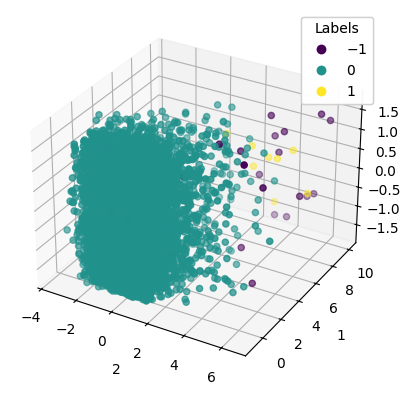

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Supponiamo che 'df' sia il tuo DataFrame e 'variable_3' sia la terza variabile
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Crea il grafico 3D
scatter = ax.scatter(train_data[2], train_data[1], train_data[0], 
                     c=dbscan.labels_, cmap='viridis')

# Aggiungi etichette agli assi
ax.set_xlabel('2')
ax.set_ylabel('1')
ax.set_zlabel('3')

# Aggiungi una legenda
legend1 = ax.legend(*scatter.legend_elements(), title="Labels")
ax.add_artist(legend1)

# Mostra il grafico
plt.show()

In [17]:
train_data.describe()

,0,1,2,3,4,5
count,1.592500e+04,1.592500e+04,1.592500e+04,1.592500e+04,1.592500e+04,1.592500e+04
mean,5.711113e-17,1.606250e-17,-1.249306e-17,2.654775e-17,-1.784723e-18,-6.246530e-18
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-1.731942e+00,-1.030415e+00,-3.472468e+00,-5.214951e+00,-4.282148e+00,-6.607285e+00
25%,-8.659710e-01,-5.928214e-01,-6.072901e-01,-5.867618e-01,-5.884839e-01,-5.736909e-01
50%,0.000000e+00,-3.037652e-01,8.902735e-02,-6.191903e-02,2.837756e-02,3.681781e-02
75%,8.659710e-01,2.175692e-01,6.141810e-01,5.286015e-01,6.119854e-01,5.911469e-01
max,1.731942e+00,1.004168e+01,6.542605e+00,7.140223e+00,8.582080e+00,9.217864e+00


In [18]:
# Calcolo delle statistiche per ogni cluster
unique_labels = set(dbscan.labels_)
cluster_stats = {}

for label in unique_labels:
    if label != -1:  # Ignora il rumore
        cluster_points = train_data[dbscan.labels_ == label]
        cluster_stats[label] = {
            'num_points': len(cluster_points),
            'mean': np.mean(cluster_points, axis=0),
            'std_dev': np.std(cluster_points, axis=0)
        }

print("Cluster Statistics:")
for label, stats in cluster_stats.items():
    print(f"Cluster {label}:")
    print(f"  Number of Points: {stats['num_points']}")
    print(f"  Mean: {stats['mean']}")
    print(f"  Standard Deviation: {stats['std_dev']}")

Cluster Statistics:
Cluster 0:
  Number of Points: 15899
  Mean: 0   -0.000131
1   -0.011366
2   -0.006075
3   -0.002146
4    0.000116
5    0.004337
dtype: float64
  Standard Deviation: 0    1.000056
1    0.953743
2    0.986329
3    0.991858
4    0.995873
5    0.981032
dtype: float64
Cluster 1:
  Number of Points: 14
  Mean: 0    0.124549
1    8.800044
2    4.112633
3    0.252446
4   -0.560225
5   -4.495759
dtype: float64
  Standard Deviation: 0    0.860795
1    0.825109
2    1.298011
3    1.254614
4    0.758203
5    1.075268
dtype: float64
